 COMPARACIÓN DEL Nº DE COPIA NORMALIZADO (NCN)
=====

¿Dónde hay mayor nº de copias de ARGs/MGEs? Según cómo se planteé la pregunta la respuesta será una u otra, así como la manera de responder.

Interesa responder a nivel de familias, no a nivel general. Asi que lo primero será separar los ARGs y los MGEs según su tipo. Interesa considerar _todos_ los ARGs en la respuesta, sean o no compartidos. E interesa, también, responder primero a nivel global y luego separar la respuesta por Ardley y Lagos.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import scikit_posthocs as sp
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Current wd: the script directory
os.chdir("../data/clean_data") #data directory
data_dir = os.getcwd()
os.chdir("../../results/NCN_study") # general results dir for these analysis
res_dir = os.getcwd()
print(os.getcwd())

/home/pak/Desktop/ARG-L/resistome/results/NCN_study


In [3]:
os.chdir(data_dir)
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)

In [4]:
# Fix names for consistency sake
all_data.loc[all_data["antib"] == "Phenicol", "antib"] = "Amphenicol"

# Fix a bunch of badly assigned resistances 
all_data.loc[all_data["antib"] == "Other", "or_seq"] = "arg" #this is the biggest one
all_data.loc[all_data["Assay"] == "dfrA1", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA12", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA1", "or_seq"] = "arg"
all_data.loc[all_data["Assay"] == "dfrA12", "or_seq"] = "arg"
all_data.loc[all_data["antib"] == "Plasmid-inc", "antib"] = "Plasmid"
all_data.loc[all_data["antib"] == "Plasmid-rep", "antib"] = "Plasmid"

all_data.head()

,Assay,antib,sample,Ct,place,type_f,type_g,or_seq,rel_n,rel_ab,log_n,rel_16
0,aacC2,Aminoglycoside,25.0,23.78,ardley,PUR,plastic,arg,9.246982,0.000222,-3.654,41686.938347
1,aacA/aphD,Aminoglycoside,25.0,26.05,ardley,PUR,plastic,arg,1.927525,0.000046,-4.335,41686.938347
2,aac(6')-II,Aminoglycoside,25.0,18.80,ardley,PUR,plastic,arg,288.403150,0.006918,-2.160,41686.938347
3,aphA3,Aminoglycoside,25.0,0.00,ardley,PUR,plastic,arg,NaN,NaN,NaN,41686.938347
4,sat4,Aminoglycoside,25.0,0.00,ardley,PUR,plastic,arg,NaN,NaN,NaN,41686.938347


In [5]:
# Now, fix some things that will give problems down the line
all_data.fillna(0, inplace = True) # this is to make it so we can use logarithms
all_data = all_data[(all_data["antib"] != "16S")] # this gets rid of the 16S data, which is no use now
all_data = all_data.loc[~all_data["place"].isin([0])] # And this removes more duds in the dataset

In [6]:
# Now we're just missing the final adjustment steps

# First, we divide the value of rel_ab in these samples because they correspond to pools of three samples
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3

# Next, we filter the df to only keep the columns that we're going to use. 
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] 
all_data.head()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000046
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.006918
3,aphA3,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000
4,sat4,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000


There's a last fix that needs to be made to the dataset: group both lakes as a general "lake" variable. I won't be able to do statistics on Ionosférico data due to the low number of replicates, so separating by sampling place is not an option. However, separating by sampling ambient (lacustrine vs inland) is. Also, I won't be dropping the original place column, as that variable is still needed to filter for common amps

In [7]:
all_data.loc[all_data["place"] == "ardley", "ambient"] = "ard"
all_data.loc[all_data["place"] != "ardley", "ambient"] = "lake"
all_data.tail()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
10309,dfrAB4,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10310,dfrC,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10311,dfrG,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10312,dfrK,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10313,dfrBmulti,Trimethoprim,14.0,ion,water,control,arg,0.0,lake


## COMPARATIVA DEL Nº DE COPIA A NIVEL GENERAL

Aquí busco responder a la pregunta más inmediata: ¿hay más copias de ARG/MGE en plásticos o en controles?

### COMPARATIVA SIN DIFERENCIAR POR PUNTO DE MUESTREO

In [8]:
os.chdir(res_dir)

In [9]:
#Voy a agrupar los datos según sean plástico o control. Mantengo el nº de muestra para tener réplicas
general_grouped = all_data.groupby(["sample", "or_seq","type_g"]) 
summed_samples = general_grouped["rel_ab"].sum() # Calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples.loc[summed_samples["sample"] < 12].head()

,sample,or_seq,type_g,rel_ab
0,1.0,arg,control,0.021727
1,1.0,mge,control,0.006081
2,2.0,arg,control,0.003814
3,2.0,mge,control,0.001262
4,3.0,arg,control,0.005013


In [10]:
# Meto un logaritmo para poder comparar resultados con uno y otro
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])

Aunque aquí suceda en menor medida, tenemos un problema recurrente sobre el tipo de test a emplear. Por un lado, un test de muestras independientes (t-test, mannwhitney) responde inmediatamente a nuestra pregunta de si plásticos o control tienen más. Por otro, está el hecho a considerar de que no sólo existen los pásticos y los controles, sino que siempre serán ARGs y MGEs, asi que quizás debiéramos tener comparaciones múltiples. Por curarme de espanto, empleo ambas aproximaciones en todo momento.

In [11]:
def statistic_mean(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

In [12]:
def get_difs(groupby_data, var = "rel_ab", detailed = False, alternative = "two-sided", significant = True, grouping_var = "type_g"):
    """
    A highly hardcoded function that I'm defining only because it will make the rest of the notebook cleaner. Designed to take a multi-indexed groupby object
    and perform some basic analysys on it: normality, homocedasticity and the corresponding test of means' difference. It probably incurs in Type I error, as it compares multiples
    pairs of control-sample samples (they are NOT paired samples, mind you)
    
    - groupby_data: the groupby object that contains the data to analyze. As it is programmed, it MUST contain a column with a descriptive, binary value: control and study samples
    - var: name of the column whose values we want to compare
    - detailed: change it to True to get a detailed printing of all the tests being conducted
    - alternative: which altenative hypothesis to feed to the paired tests. I0m running scipy tests, so it works with the same values (less, two-sided, greater)
    - significant: if True, keep just those with pval < 0.05; if False, keep everything
    """
    result_dict = {}
    for name, group in groupby_data:
        name = str(name).upper()
        pl_data = group.loc[group[grouping_var] == "plastic"][var]
        con_data = group.loc[group[grouping_var] == "control"][var]
        
        # Tests de normalidad
        norm_plas = stats.shapiro(pl_data)
        norm_con = stats.shapiro(con_data)
        
        # Tests de homocedasticidad
        if (norm_plas[1] > 0.05) and (norm_con[1] > 0.05):
            norm = True
            homo = stats.bartlett(pl_data, con_data)
        else: 
            norm = False
            homo = stats.levene(pl_data, con_data)
            
        # Test de igualdad de distribuciones
        if (homo[1] > 0.05) and (norm == True): 
            result = stats.ttest_ind(a = pl_data, b = con_data, alternative = alternative)
        elif (homo[1] > 0.05): #homocedásticos no normales
            result = stats.mannwhitneyu(x = pl_data, y = con_data, alternative = alternative)
        elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
            result = stats.ttest_ind(a = pl_data, b = con_data, alternative = alternative, equal_var = False)
            result = ("Welch!", result[1], result[0])
        else: #todo mal, permuta
            result = stats.permutation_test(data = (pl_data, con_data), statistic =  statistic_mean, 
                                            vectorized = True, n_resamples = 20000,
                                            alternative = alternative, permutation_type = "independent")
            result = ("Permutation", result.pvalue, result.statistic) #ugly hack!
        if significant == True:
            if result[1] < 0.05: result_dict[name] = result
        else: 
            result_dict[name] = result
                
        if detailed == True:
            print("##########", name, "#########")
            print("### PLASTIC NORMALITY ###")
            print(norm_plas)
            print("### CONTROL NORMALITY ###")
            print(norm_con)
            print("### BOTH ###")
            print(homo)
            print("### DIFFERENCES ###")
            print(result)
            print("")
        result_dict = [name, 
                      "### PLASTIC NORMALITY ###",
                      str(norm_plas),
                      "### CONTROL NORMALITY ###",
                      str(norm_con),
                      "### BOTH ###",
                      str(homo),
                      "### DIFFERENCES ###",
                      str(result)]
        "\n".join(result_dict)
    return result_dict

In [13]:
general_difs = get_difs(summed_samples.groupby("or_seq"), var = "rel_ab", 
                        detailed = True, alternative = "two-sided", significant = True)
print(" ##### LOG 2 RESULTS #####")
general_log_difs = get_difs(summed_samples.groupby("or_seq"), var = "n_log2", 
                        detailed = True, alternative = "two-sided", significant = True)

with open("pair_statistics.txt", "w") as file:
    print("Significant, NCN results: ", general_difs, file = file)
    print(" ##### LOG 2 RESULTS #####")
    print("Significant, log2 NCN results: ", general_log_difs, file = file)

########## ARG #########
### PLASTIC NORMALITY ###
ShapiroResult(statistic=0.691269982543163, pvalue=0.00013544594640981455)
### CONTROL NORMALITY ###
ShapiroResult(statistic=0.5957441000121937, pvalue=2.250715156226249e-05)
### BOTH ###
LeveneResult(statistic=4.091067481512318, pvalue=0.05393097941978624)
### DIFFERENCES ###
MannwhitneyuResult(statistic=115.0, pvalue=0.1909822111581143)

########## MGE #########
### PLASTIC NORMALITY ###
ShapiroResult(statistic=0.6835975664555536, pvalue=0.00011194586457594759)
### CONTROL NORMALITY ###
ShapiroResult(statistic=0.6202633674823157, pvalue=4.5513379453175765e-05)
### BOTH ###
LeveneResult(statistic=4.559233033815321, pvalue=0.042724503118162324)
### DIFFERENCES ###
('Permutation', 0.05079746012699365, 5.485798378824897)

 ##### LOG 2 RESULTS #####
########## ARG #########
### PLASTIC NORMALITY ###
ShapiroResult(statistic=0.6881125110301318, pvalue=0.00012519311513197392)
### CONTROL NORMALITY ###
ShapiroResult(statistic=0.844045620215620

In [14]:
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

In [15]:
# Empiezo con algo tontorrón: los colores a usar
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

In [16]:
# Ahora posiciones de elementos decorativos
means_arg = [value for name, value in arg_general_sums.groupby("type_g")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log = [value for name, value in arg_general_sums.groupby("type_g")["n_log2"].mean().items()]
names = [name for name, value in summed_samples.groupby("type_g")["rel_ab"].mean().items()]
means_mge = [value for name, value in mge_general_sums.groupby("type_g")["rel_ab"].mean().items()]
means_mge_log = [value for name, value in mge_general_sums.groupby("type_g")["n_log2"].mean().items()]
#print(list(zip(means, names)))
#necesario darle la vuelta 
#means.reverse()

In [17]:
def make_chuli_plot_violin(data, x, y, mean_list, line_list, title, figsize, orient = "horizontal"):
    # Ya la figura ------------------------------------------
    fig, ax = plt.subplots(figsize = figsize)

    #Color de fondo
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Líneas horizontales de escala
    for hline in line_list:
        if orient == "horizontal":
            ax.axvline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
        else:
            ax.axhline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
    # Violines
    violins = sns.violinplot(data = data, x = x, y = y,
                            cut = 0.1, scale = "count", inner = None, legend = False,
                            bw = "silverman", linewidth = 1.5)

    # Cajas
    boxes = sns.boxplot(data = data, x = x, y = y,  
                        boxprops = {"zorder": 2, "facecolor": "none", "linewidth": 1.4},
                        whiskerprops = {"color": BLACK, "linewidth": 1.4},
                        medianprops = {"color": GREY_DARK, "solid_capstyle": "butt", "linewidth": 4},
                        showcaps = False
                       )
    #Stripplot
    points = sns.stripplot(data = data, x = x, y = y, 
                           s = 15, alpha = 0.9, linewidth = 1, legend = False, palette = "deep")

    # Customize violins (remove fill, customize line, etc.)
    for collection in ax.collections:
        if isinstance(collection, matplotlib.collections.PolyCollection):
            collection.set_edgecolor(BLACK)
            collection.set_facecolor('none')

    # Add mean value labels ------------------------------------------
    if orient == "horizontal":
        for mean, pos in zip(mean_list[:], ax.get_yticks()):
            # Add dot representing the mean
            ax.scatter(mean, pos, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            # Add line conecting mean value and its label
            ax.plot([mean, mean], [pos, pos + 0.3], ls="dashdot", color="black", zorder=3)
            # Add mean value label.
            ax.text(mean, pos +0.3,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor":BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )
    else:
        for mean, pos in zip(mean_list[:], ax.get_xticks()):
            ax.scatter(pos, mean, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            ax.plot([pos, pos + 0.3], [mean, mean], ls="dashdot", color="black", zorder=3)
            ax.text(pos + 0.3, mean,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor": BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )

    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title(title.upper())
    plt.legend([],[], frameon=False) #ugly hack!

In [18]:
def make_chuli_plot(data, x, y, mean_list, line_list, title, figsize, orient = "horizontal"):
    # Ya la figura ------------------------------------------
    fig, ax = plt.subplots(figsize = figsize)

    #Color de fondo
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Líneas horizontales de escala
    for hline in line_list:
        if orient == "horizontal":
            ax.axvline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
        else:
            ax.axhline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)

    # Cajas
    boxes = sns.boxplot(data = data, x = x, y = y,  
                        boxprops = {"zorder": 2, "facecolor": "none", "linewidth": 1.4},
                        whiskerprops = {"color": BLACK, "linewidth": 1.4},
                        medianprops = {"color": GREY_DARK, "solid_capstyle": "butt", "linewidth": 4},
                        showcaps = False
                       )
    #Stripplot
    points = sns.stripplot(data = data, x = x, y = y, 
                           s = 15, alpha = 0.9, linewidth = 1, legend = False, palette = "deep")
    # Add mean value labels ------------------------------------------
    if orient == "horizontal":
        for mean, pos in zip(mean_list[:], ax.get_yticks()):
            # Add dot representing the mean
            ax.scatter(mean, pos, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            # Add line conecting mean value and its label
            ax.plot([mean, mean], [pos, pos + 0.3], ls="dashdot", color="black", zorder=3)
            # Add mean value label.
            ax.text(mean, pos +0.3,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor":BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )
    else:
        for mean, pos in zip(mean_list[:], ax.get_xticks()):
            ax.scatter(pos, mean, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            ax.plot([pos, pos + 0.3], [mean, mean], ls="dashdot", color="black", zorder=3)
            ax.text(pos + 0.3, mean,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor": BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )

    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title(title.upper())
    plt.legend([],[], frameon=False) #ugly hack!

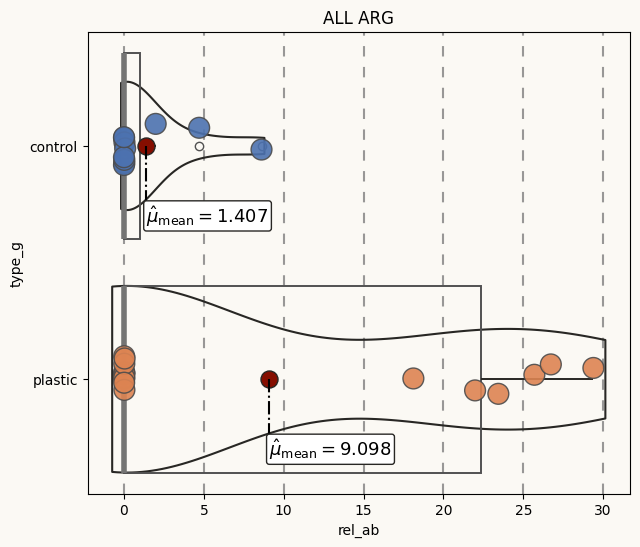

In [19]:
hlines = [0, 5, 10, 15, 20, 25, 30] #sacadas de observar el gráfico-borrador y ver en torno a qué valores van a estar nuestros datos
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "rel_ab",
                       y = "type_g",
                       mean_list = means_arg, line_list = hlines,
                       title = "ALL ARG",
                       figsize = (7, 6),
                       )
plt.savefig("All ARG.png", bbox_inches= "tight")

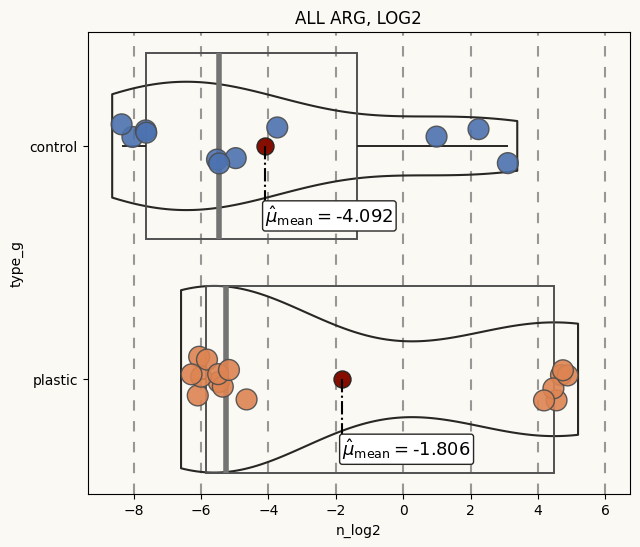

In [20]:
hlines_log = [-8, -6, -4, -2, 0, 2, 4, 6]
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "n_log2",
                       y = "type_g",
                       mean_list = means_arg_log, line_list = hlines_log,
                       title = "ALL ARG, LOG2",
                       figsize = (7, 6),
                       )
plt.savefig("All ARG-log2.png", bbox_inches= "tight")

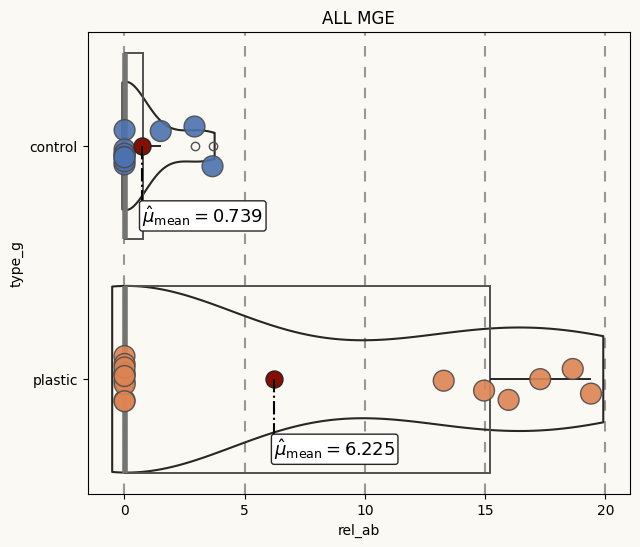

In [21]:
hlines = [0, 5, 10, 15, 20]
make_chuli_plot_violin(data = mge_general_sums, x = "rel_ab", y = "type_g", mean_list = means_mge, line_list = hlines, title = "ALL MGE", figsize = (7, 6))
plt.savefig("All MGE.png", bbox_inches= "tight")

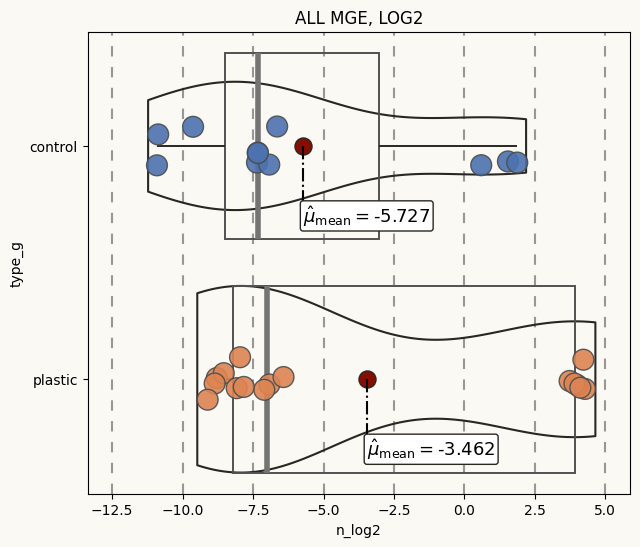

In [22]:
hlines_log = [-12.5, -10, -7.5, -5, -2.5, 0, 2.5, 5]
make_chuli_plot_violin(data = mge_general_sums, x = "n_log2", y = "type_g", mean_list = means_mge_log, line_list = hlines_log, title = "ALL MGE, LOG2", figsize = (7, 6))
plt.savefig("All MGE-log2.png", bbox_inches= "tight")

### COMPARATIVA DIFERENCIANDO SITIOS DE MUESTREO
No se han obtenido diferencias significativas entre muestras, pero como se observa en los gráficos, esto probablemente se deba a que las muestras de los lagos y las del ardley son completamente distintas. Asi que vamos a comprobar que ese sea el caso

In [23]:
sp_grouped = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.loc[summed_samples["sample"] == 21]

,sample,or_seq,ambient,type_g,type_f,rel_ab,n_log2
40,21.0,arg,ard,control,soil,1.986300,0.990083
41,21.0,mge,ard,control,soil,1.510478,0.595005


In [24]:
summed_samples["hacky"] = summed_samples["ambient"] + "+" + summed_samples["type_g"]
summed_samples.head()

,sample,or_seq,ambient,type_g,type_f,rel_ab,n_log2,hacky
0,1.0,arg,lake,control,soil,0.021727,-5.524342,lake+control
1,1.0,mge,lake,control,soil,0.006081,-7.361481,lake+control
2,2.0,arg,lake,control,soil,0.003814,-8.034327,lake+control
3,2.0,mge,lake,control,soil,0.001262,-9.630372,lake+control
4,3.0,arg,lake,control,soil,0.005013,-7.640205,lake+control


In [25]:
var_lst = [group["rel_ab"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["hacky"])] 
nam_lst = [name for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["hacky"])] 
print("Regular values: ", stats.levene(*var_lst))
print("Regular values: ", stats.kruskal(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["hacky"])]
print("Log2: ", stats.levene(*var_lst_ln))
print("Log2: ", stats.kruskal(*var_lst_ln))

Regular values:  LeveneResult(statistic=11.569870032065877, pvalue=7.994452213048832e-05)
Regular values:  KruskalResult(statistic=18.28928571428571, pvalue=0.00038337055060923557)
Log2:  LeveneResult(statistic=13.843518512500859, pvalue=2.2791354211843012e-05)
Log2:  KruskalResult(statistic=18.28928571428571, pvalue=0.00038337055060923557)


In [26]:
posthoc = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
posthoc.rename(columns = {original_num:new_name for (original_num, new_name) in zip(posthoc.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(posthoc.index, nam_lst)},
                         inplace = True)
print(posthoc)

                 (ard+control,)  (ard+plastic,)  (lake+control,)  \
(ard+control,)         1.000000        0.215296         0.002160   
(ard+plastic,)         0.215296        1.000000         0.000008   
(lake+control,)        0.002160        0.000008         1.000000   
(lake+plastic,)        0.006361        0.000014         0.362576   

                 (lake+plastic,)  
(ard+control,)          0.006361  
(ard+plastic,)          0.000014  
(lake+control,)         0.362576  
(lake+plastic,)         1.000000  


Como se ve, claramente hay diferencias entre sitios, aunque no dentro de un mismo sitio entre plásticos y no plásticos. Como no me creo que ese sea el caso, sino que lo que sucede es que queda oculta la diferencia entre plástico y control en la diferencia entre sitios, pruebo otra cosa: primero demostrar que existe la diferencia entre sitios, y después que dentro de cada sitio existen diferencias entre plástico y control

### COMPARATIVA DE SITIOS DE MUESTREO EN SÍ ENTRE SÍ

In [27]:
general_grouped = all_data.groupby(["sample", "or_seq","ambient"]) # Misma idea, pero esta vez agrupo por el sitio de muestreo en vez de por el tipo de muestra 
summed_samples = general_grouped["rel_ab"].sum() 
summed_samples = summed_samples.reset_index() 
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.tail()

,sample,or_seq,ambient,rel_ab,n_log2
49,25.0,mge,ard,13.276906,3.730847
50,26.0,arg,ard,18.119255,4.179452
51,26.0,mge,ard,14.954714,3.902528
52,27.0,arg,ard,26.724989,4.740117
53,27.0,mge,ard,17.291198,4.111966


In [28]:
# Ahora voy a hacer las comparativas. Esta vez comparo lago vs ard, en vez de plas vs control.
# Como la función que definí antes es un desastre hardcodeado a muerte, la rehago aquí. Sad!
for name, group in summed_samples.groupby("or_seq"):
    name = str(name).upper()
    ard_data = group.loc[group["ambient"] == "ard"]["n_log2"]
    lake_data = group.loc[group["ambient"] == "lake"]["n_log2"]
        
    # Tests de normalidad
    norm_ard = stats.shapiro(ard_data)
    norm_lake = stats.shapiro(lake_data)
        
    # Tests de homocedasticidad
    if (norm_ard[1] > 0.05) and (norm_lake[1] > 0.05):
        norm = True
        homo = stats.bartlett(ard_data, lake_data)
    else: 
        norm = False
        homo = stats.levene(ard_data, lake_data)
            
    # Test de igualdad de distribuciones
    if (homo[1] > 0.05) and (norm == True): 
        result = stats.ttest_ind(a = ard_data, b = lake_data, alternative = "two-sided")
    elif (homo[1] > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = ard_data, y = lake_data, alternative = "two-sided")
    elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
        result = stats.ttest_ind(a = ard_data, b = lake_data, alternative = "two-sided", equal_var = False)
        result = ("Welch!", result[1], result[0])
    else: #todo mal, permuta
        # it will normally permute, but I'm already treading shaky ground to stack a pèrmutation test on top of it. So I'm doing it via MWW
        #result = stats.permutation_test(data = (ard_data, lake_data), statistic =  statistic_mean, 
        #                                vectorized = True, n_resamples = 20000,
        #                                alternative = "two-sided", permutation_type = "independent")
        #result = ("Permutation", result.pvalue, result.statistic) #ugly hack!
        result = stats.ttest_ind(a = ard_data, b = lake_data, alternative = "two-sided", equal_var = False)
        result = ("Welch!", result[1], result[0])
    print("##########", name, "#########")
    print("### ARD NORMALITY ###")
    print(norm_ard)
    print("### LAKE NORMALITY ###")
    print(norm_lake)
    print("### BOTH HOMOCEDASTICITY ###")
    print(homo)
    print("### DIFFERENCES ###")
    print(result)
    print("")


########## ARG #########
### ARD NORMALITY ###
ShapiroResult(statistic=0.8048148890285476, pvalue=0.023173702242028946)
### LAKE NORMALITY ###
ShapiroResult(statistic=0.9252570541932108, pvalue=0.16016381081080555)
### BOTH HOMOCEDASTICITY ###
LeveneResult(statistic=0.006978111516802098, pvalue=0.9340913786823631)
### DIFFERENCES ###
MannwhitneyuResult(statistic=162.0, pvalue=3.465900661488035e-05)

########## MGE #########
### ARD NORMALITY ###
ShapiroResult(statistic=0.7823587009673999, pvalue=0.012820577922906489)
### LAKE NORMALITY ###
ShapiroResult(statistic=0.9147333878912246, pvalue=0.1042949114490836)
### BOTH HOMOCEDASTICITY ###
LeveneResult(statistic=0.025321683644419456, pvalue=0.8748466948551729)
### DIFFERENCES ###
MannwhitneyuResult(statistic=162.0, pvalue=3.465900661488035e-05)



Una vez demostrada la existencia de diferencias entre sitios de muestreo, solo queda comprobar la diferencia, dentro de un mismo sitio de muestreo, de diferencias entre tipos de muestra. Asi que a ello

In [29]:
#### ARDLEY ####
general_grouped = all_data.loc[all_data["ambient"] == "ard"].groupby(["sample", "or_seq","type_g"]) 
summed_samples = general_grouped["rel_ab"].sum() # Calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.head()

for name, group in summed_samples.groupby("or_seq"):
    name = str(name).upper()
    pl_data = group.loc[group["type_g"] == "plastic"]["n_log2"]
    con_data = group.loc[group["type_g"] == "control"]["n_log2"]
    
    norm_plas = stats.shapiro(pl_data)
    norm_con = stats.shapiro(con_data)
        
    if (norm_plas[1] > 0.05) and (norm_con[1] > 0.05):
        norm = True
        #homo = stats.bartlett(pl_data, con_data)
        homo = stats.levene(pl_data, con_data)
    else: 
        norm = False
        homo = stats.levene(pl_data, con_data)
            
    if (homo[1] > 0.05) and (norm == True): 
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided")
    elif (homo[1] > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = pl_data, y = con_data, alternative = "two-sided")
    elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided", equal_var = False)
        result = ("Welch!", result[1], result[0])
    else: #todo mal, permuta
        result = stats.permutation_test(data = (pl_data, con_data), statistic =  statistic_mean, 
                                        vectorized = True, n_resamples = 20000,
                                        alternative = "two-sided", permutation_type = "independent")
        result = ("Permutation", result.pvalue, result.statistic) #ugly hack!

    print("##########", name, "#########")
    print("### PLASTIC ###")
    print(norm_plas)
    print("### CONTROL ###")
    print(norm_con)
    print("### BOTH ###")
    print(homo)
    print("### DIFFERENCES ###")
    print(result)
    print("")


########## ARG #########
### PLASTIC ###
ShapiroResult(statistic=0.9676128207775098, pvalue=0.876032170555759)
### CONTROL ###
ShapiroResult(statistic=0.9896825726705084, pvalue=0.8056713969756095)
### BOTH ###
LeveneResult(statistic=4.121656147399954, pvalue=0.08189026958235138)
### DIFFERENCES ###
TtestResult(statistic=5.774815582686206, pvalue=0.0006808568150268115, df=7.0)

########## MGE #########
### PLASTIC ###
ShapiroResult(statistic=0.966174886754637, pvalue=0.8658246859923315)
### CONTROL ###
ShapiroResult(statistic=0.9277076833737645, pvalue=0.4800942174260764)
### BOTH ###
LeveneResult(statistic=1.8758916833516772, pvalue=0.21311857998586642)
### DIFFERENCES ###
TtestResult(statistic=9.683943540181756, pvalue=2.6428396892907362e-05, df=7.0)



In [30]:
#### LAKES ####
#alt_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)]
#general_grouped = alt_data.groupby(["sample", "or_seq", "ambient", "type_f"])

general_grouped = all_data.loc[all_data["ambient"] == "lake"].groupby(["sample", "or_seq","type_g"])
#general_grouped = alt_data.loc[all_data["ambient"] == "lake"].groupby(["sample", "or_seq","type_g"]) 
summed_samples = general_grouped["rel_ab"].sum() # Calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.head()

for name, group in summed_samples.groupby("or_seq"):
    name = str(name).upper()
    pl_data = group.loc[group["type_g"] == "plastic"]["n_log2"]
    con_data = group.loc[group["type_g"] == "control"]["n_log2"]
    
    norm_plas = stats.shapiro(pl_data)
    norm_con = stats.shapiro(con_data)
        
    if (norm_plas[1] > 0.05) and (norm_con[1] > 0.05):
        norm = True
        homo = stats.bartlett(pl_data, con_data)
        #homo = stats.levene(pl_data, con_data)
    else: 
        norm = False
        homo = stats.levene(pl_data, con_data)
            
    if (homo[1] > 0.05) and (norm == True): 
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided")
    elif (homo[1] > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = pl_data, y = con_data, alternative = "two-sided")
    elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided", equal_var = False)
        result = ("Welch!", result[1], result[0])
    else: #todo mal, permuta
        result = stats.permutation_test(data = (pl_data, con_data), statistic =  statistic_mean, 
                                        vectorized = True, n_resamples = 20000,
                                        alternative = "two-sided", permutation_type = "independent")
        result = ("Permutation", result.pvalue, result.statistic) #ugly hack!

    print("##########", name, "#########")
    print("### PLASTIC ###")
    print(norm_plas)
    print("### CONTROL ###")
    print(norm_con)
    print("### BOTH ###")
    print(homo)
    print("### DIFFERENCES ###")
    print(result)
    print("")


########## ARG #########
### PLASTIC ###
ShapiroResult(statistic=0.943310686282404, pvalue=0.5904049852024067)
### CONTROL ###
ShapiroResult(statistic=0.8951347716608592, pvalue=0.2610153203690414)
### BOTH ###
BartlettResult(statistic=9.772312380439187, pvalue=0.0017715949866720917)
### DIFFERENCES ###
('Welch!', 0.24616720671938724, 1.251510656292721)

########## MGE #########
### PLASTIC ###
ShapiroResult(statistic=0.9416187639241338, pvalue=0.5711626586851957)
### CONTROL ###
ShapiroResult(statistic=0.7954294252583742, pvalue=0.02557060267244961)
### BOTH ###
LeveneResult(statistic=1.3274398004826786, pvalue=0.2661860459460131)
### DIFFERENCES ###
MannwhitneyuResult(statistic=42.0, pvalue=0.8967503085150144)



#### ARG

In [31]:
#alt_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)]
#sp_grouped = alt_data.groupby(["sample", "or_seq", "ambient", "type_f"])

sp_grouped = all_data.groupby(["sample", "or_seq", "ambient", "type_f"])
summed_samples = sp_grouped["rel_ab"].sum() 
summed_samples = summed_samples.reset_index() 
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.loc[summed_samples["sample"] == 21]

,sample,or_seq,ambient,type_f,rel_ab,n_log2
40,21.0,arg,ard,soil,1.986300,0.990083
41,21.0,mge,ard,soil,1.510478,0.595005


In [32]:
for ambient in summed_samples["ambient"].unique():
    print("Working on ", ambient.upper())
    ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
    var_lst = [group["rel_ab"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby(["type_f"])] #contains every group
    nam_lst = [name for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby(["type_f"])] #contains the name of everygroup, SAME ORDER
    print("Regular values: ", stats.levene(*var_lst))
    var_lst_ln = [group["n_log2"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby(["type_f"])]
    print("Log2: ", stats.levene(*var_lst_ln))
    print(stats.kruskal(*var_lst_ln))
    posthoc = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
    posthoc.rename(columns = {original_num:new_name for (original_num, new_name) in zip(posthoc.columns, nam_lst)},
                   index = {original_num:new_name for (original_num, new_name) in zip(posthoc.index, nam_lst)},
                   inplace = True)
    print(posthoc)
    fname = ambient.upper() + "-all_posthoc.csv"
    posthoc.to_csv(fname)

Working on  LAKE
Regular values:  LeveneResult(statistic=1.7613964891087652, pvalue=0.2006061305949764)
Log2:  LeveneResult(statistic=1.0484747888247319, pvalue=0.4018887593456237)
KruskalResult(statistic=6.026315789473678, pvalue=0.11033690049010722)
            (EPS,)    (PUR,)   (soil,)  (water,)
(EPS,)    1.000000  0.895456  0.141577  0.610510
(PUR,)    0.895456  1.000000  0.141577  0.610510
(soil,)   0.141577  0.141577  1.000000  0.121502
(water,)  0.610510  0.610510  0.121502  1.000000
Working on  ARD
Regular values:  LeveneResult(statistic=0.5879399216299993, pvalue=0.5845588999089493)
Log2:  LeveneResult(statistic=1.9440488694272255, pvalue=0.2234166314651927)
KruskalResult(statistic=5.600000000000001, pvalue=0.06081006262521791)
           (EPS,)    (PUR,)   (soil,)
(EPS,)   1.000000  0.506021  0.045030
(PUR,)   0.506021  1.000000  0.036855
(soil,)  0.045030  0.036855  1.000000


Esto personalmente me mata, pero sé que si ahora se vuelve a estudiar de manera conjunta ardley y lagos, van a a aparecer diferencias

In [33]:
summed_samples["hacky"] = summed_samples["ambient"] + "+" + summed_samples["type_f"]
var_lst = [group["rel_ab"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["hacky"])] 
nam_lst = [name for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["hacky"])] 
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["hacky"])]
print("Log2: ", stats.levene(*var_lst_ln))
print(stats.kruskal(*var_lst_ln))
posthoc = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
posthoc.rename(columns = {original_num:new_name for (original_num, new_name) in zip(posthoc.columns, nam_lst)},
               index = {original_num:new_name for (original_num, new_name) in zip(posthoc.index, nam_lst)},
               inplace = True)
print(posthoc)

Regular values:  LeveneResult(statistic=2.9679137380466556, pvalue=0.030736517172216423)
Log2:  LeveneResult(statistic=1.1303033112677472, pvalue=0.38075210741546744)
KruskalResult(statistic=20.75, pvalue=0.002034281837408599)
               (ard+EPS,)  (ard+PUR,)  (ard+soil,)  (lake+EPS,)  (lake+PUR,)  \
(ard+EPS,)       1.000000    0.804714     0.299423     0.000638     0.000544   
(ard+PUR,)       0.804714    1.000000     0.193906     0.000409     0.000375   
(ard+soil,)      0.299423    0.193906     1.000000     0.009294     0.007513   
(lake+EPS,)      0.000638    0.000409     0.009294     1.000000     0.877968   
(lake+PUR,)      0.000544    0.000375     0.007513     0.877968     1.000000   
(lake+soil,)     0.000029    0.000029     0.000340     0.040705     0.047912   
(lake+water,)    0.003964    0.002105     0.045189     0.486165     0.421240   

               (lake+soil,)  (lake+water,)  
(ard+EPS,)         0.000029       0.003964  
(ard+PUR,)         0.000029       0.002105

En fin, una pena

#### MGE

In [34]:
for ambient in summed_samples["ambient"].unique():
    print("Working on ", ambient.upper())
    ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
    var_lst = [group["rel_ab"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby(["type_f"])] #contains every group
    nam_lst = [name for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby(["type_f"])] #contains the name of everygroup, SAME ORDER
    print("Regular values: ", stats.levene(*var_lst))
    var_lst_ln = [group["n_log2"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby(["type_f"])]
    print("Log2: ", stats.levene(*var_lst_ln))
    print(stats.kruskal(*var_lst_ln))
    posthoc = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
    posthoc.rename(columns = {original_num:new_name for (original_num, new_name) in zip(posthoc.columns, nam_lst)},
                   index = {original_num:new_name for (original_num, new_name) in zip(posthoc.index, nam_lst)},
                   inplace = True)
    print(posthoc)
    fname = ambient.upper() + "-all_posthoc.csv"
    posthoc.to_csv(fname)

Working on  LAKE
Regular values:  LeveneResult(statistic=0.5360746062440725, pvalue=0.6651431434183729)
Log2:  LeveneResult(statistic=0.9706665114108826, pvalue=0.43417583937376447)
KruskalResult(statistic=1.4526315789473685, pvalue=0.6932452777334324)
            (EPS,)    (PUR,)   (soil,)  (water,)
(EPS,)    1.000000  0.765368  0.906780  0.765368
(PUR,)    0.765368  1.000000  0.765368  0.906780
(soil,)   0.906780  0.765368  1.000000  0.765368
(water,)  0.765368  0.906780  0.765368  1.000000
Working on  ARD
Regular values:  LeveneResult(statistic=0.23629168598983535, pvalue=0.7965642138457337)
Log2:  LeveneResult(statistic=1.1720571741233217, pvalue=0.3718031029891118)
KruskalResult(statistic=6.488888888888894, pvalue=0.03899021957448701)
           (EPS,)    (PUR,)   (soil,)
(EPS,)   1.000000  0.082814  0.007003
(PUR,)   0.082814  1.000000  0.037415
(soil,)  0.007003  0.037415  1.000000


And now

## Datos diferenciados por familia

The idea here is to generate results on a per-family basis

In [35]:
os.chdir("fam_res")
os.chdir("general")
typeg_dir = os.getcwd()
os.chdir("../type_f")
typef_dir = os.getcwd()
os.chdir("..")

Now, the comparisons that are just plastic vs control should be done via pair tests (MWW, ttest, etc), while the detailed type comparisons need multiple comparisons and posthoc adjustment of the pvalue. As every framework of testing has been used in this script, its just a matter of using the adecuate one when its appropiate and adapting it to run in a loop.

In [36]:
os.chdir(typeg_dir)

In [37]:
test = all_data.groupby(["sample", "type_g", "antib", "ambient"])
summed = test["rel_ab"].sum().reset_index()
summed["n_log2"] = np.log2(summed["rel_ab"] + 1)
summed.head()

,sample,type_g,antib,ambient,rel_ab,n_log2
0,1.0,control,Aminoglycoside,lake,0.019462,0.027808
1,1.0,control,Amphenicol,lake,0.000000,0.000000
2,1.0,control,Beta Lactam,lake,0.000000,0.000000
3,1.0,control,Fluoroquinolone,lake,0.000000,0.000000
4,1.0,control,Insertional,lake,0.003366,0.004848


In [38]:
summed["group"] = summed["antib"] + "+" + summed["ambient"]

for group in summed["group"].unique():
    group_df = summed.loc[summed["group"] == group]
    pl_data = group_df.loc[summed["type_g"] == "plastic"]["n_log2"]
    con_data = group_df.loc[summed["type_g"] == "control"]["n_log2"]

    norm_plas = stats.shapiro(pl_data)
    norm_con = stats.shapiro(con_data)
        
    if (norm_plas[1] > 0.05) and (norm_con[1] > 0.05):
        norm = True
        homo = stats.bartlett(pl_data, con_data)
    else: 
        norm = False
        homo = stats.levene(pl_data, con_data)
            
    if (homo[1] > 0.05) and (norm == True): 
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided")
    elif (homo[1] > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = pl_data, y = con_data, alternative = "two-sided")
    elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided", equal_var = False)
        result = ("Welch!", result[0], result[1])
    else: 
        result = stats.permutation_test(data = (pl_data, con_data), statistic =  statistic_mean, 
                                        vectorized = True, n_resamples = 20000,
                                        alternative = "two-sided", permutation_type = "independent")
        result = ("Permutation", result.pvalue, result.statistic) #ugly hack!

    fname = group.upper() + ".txt"
    with open(fname, "w") as file:
        print("##### ", group.upper(), " ####", file = file)
        print("### PLASTIC NORMALITY ###", file = file)
        print(norm_plas, file = file)
        print("### CONTROL NORMALITY ###", file = file)
        print(norm_con, file = file)
        print("### BOTH ###", file = file)
        print(homo, file = file)
        print("### DIFFERENCES ###", file = file)
        print(result, file = file)
        print("", file = file)

And now the multiple comparisons part of the equation with all types considered at once

In [39]:
os.chdir(typef_dir)

In [40]:
for antib in all_data["antib"].unique():
    print("##### Working on ", antib.upper(), " #####")
    antib_data = all_data.loc[all_data["antib"] == antib]
        
    sp_grouped = antib_data.groupby(["sample", "ambient", "type_f"]) 
    summed_samples = sp_grouped["rel_ab"].sum() 
    summed_samples = summed_samples.reset_index() 
    summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"] + 1)

    for ambient in summed_samples["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby(["type_f"])] 
        nam_lst = [name for name, group in ambient_samples.groupby(["type_f"])] 
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby(["type_f"])]
        fname = antib.upper() + "-" + ambient.upper() + "-" + "-statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            try:
                print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
                print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
                print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            except:
                print("Log2_values: ", stats.levene(*var_lst_ln), file = file)     
        posthoc = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
        posthoc.rename(columns = {original_num:new_name for (original_num, new_name) in zip(posthoc.columns, nam_lst)},
                       index = {original_num:new_name for (original_num, new_name) in zip(posthoc.index, nam_lst)},
                       inplace = True)
        fname = antib.upper() + "-" + ambient.upper() + "-" + ".csv"
        posthoc.to_csv(fname)

##### Working on  AMINOGLYCOSIDE  #####
Working on  LAKE
Working on  ARD
##### Working on  AMPHENICOL  #####
Working on  LAKE
Working on  ARD
##### Working on  VANCOMYCIN  #####
Working on  LAKE
Working on  ARD
##### Working on  BETA LACTAM  #####
Working on  LAKE
Working on  ARD
##### Working on  MDR  #####
Working on  LAKE
Working on  ARD
##### Working on  TRIMETHOPRIM  #####
Working on  LAKE
Working on  ARD
##### Working on  OTHER  #####
Working on  LAKE
Working on  ARD
##### Working on  FLUOROQUINOLONE  #####
Working on  LAKE
Working on  ARD
##### Working on  MLSB  #####
Working on  LAKE
Working on  ARD
##### Working on  TETRACYCLINE  #####
Working on  LAKE
Working on  ARD
##### Working on  INSERTIONAL  #####
Working on  LAKE
Working on  ARD
##### Working on  INTEGRASE  #####
Working on  LAKE
Working on  ARD
##### Working on  MGE  #####
Working on  LAKE
Working on  ARD
##### Working on  PLASMID  #####
Working on  LAKE
Working on  ARD
##### Working on  SULFONAMIDE  #####
Working on 

### GRÁFICOS DE FAMILIAS

Los gráficos que se generan en loop son una mierda, siendo suaves. Y enormes. Queremos gráficos más chiquitujos con los que hacer un plot compuesto en el que se vean todos a la vez. A ver si puedo recrearlo

In [41]:
am_df = all_data.loc[all_data["antib"] == "Aminoglycoside"]
# por ahora ignoro la separación ardley-lagos
am_df.head()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222,ard
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000046,ard
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.006918,ard
3,aphA3,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000,ard
4,sat4,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000,ard


In [42]:
summed_am = all_data.groupby(["sample", "ambient", "type_g"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_am["hacky"] = summed_am["ambient"] + " " + summed_am["type_g"]
summed_am.sort_values(by = "hacky", inplace = True)
summed_am["n_log2"] = np.log2(summed_samples["rel_ab"] + 1)
summed_am.head()

,sample,ambient,type_g,rel_ab,hacky,n_log2
20,21.0,ard,control,3.496778,ard control,0.001217
19,20.0,ard,control,12.274584,ard control,0.016548
18,19.0,ard,control,7.622548,ard control,0.009951
26,27.0,ard,plastic,44.016187,ard plastic,0.428948
24,25.0,ard,plastic,42.666928,ard plastic,0.414608


In [43]:
os.chdir("..")

In [44]:
os.getcwd()

'/home/pak/Desktop/ARG-L/resistome/results/NCN_study/fam_res'

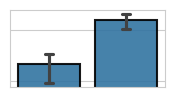

In [45]:
plt.figure(figsize = (2,1))
sns.set_style("whitegrid")
am = sns.barplot(data = summed_am, x="type_g", y="rel_ab",alpha = 0.9,
                 errorbar = "se", capsize = 0.1,
                 width=0.8, 
                 fill = True, linewidth = 1.5, edgecolor = "black")
plt.yscale("log")
am.set(xticklabels = [], yticklabels = [],
      xlabel=None, ylabel = None)
plt.savefig("testing.png", bbox_inches= "tight")

Ahora voy a intentar lo mismo, pero para todos los ARGs a la vez

In [46]:
summed = all_data.loc[all_data["ambient"] == "ard"].groupby(["sample", "type_g", "antib", "or_seq"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
#summed["hacky"] = summed_am["ambient"] + " " + summed_am["type_g"]
summed["hacky"] = summed["or_seq"] + " " + summed["antib"]
summed.sort_values(by = "hacky", inplace = True)
summed.head()

,sample,type_g,antib,or_seq,rel_ab,hacky
0,19.0,control,Aminoglycoside,arg,0.435927,arg Aminoglycoside
80,24.0,plastic,Aminoglycoside,arg,6.391315,arg Aminoglycoside
48,22.0,plastic,Aminoglycoside,arg,7.923626,arg Aminoglycoside
112,26.0,plastic,Aminoglycoside,arg,7.386266,arg Aminoglycoside
32,21.0,control,Aminoglycoside,arg,0.197495,arg Aminoglycoside


<Figure size 400x400 with 0 Axes>

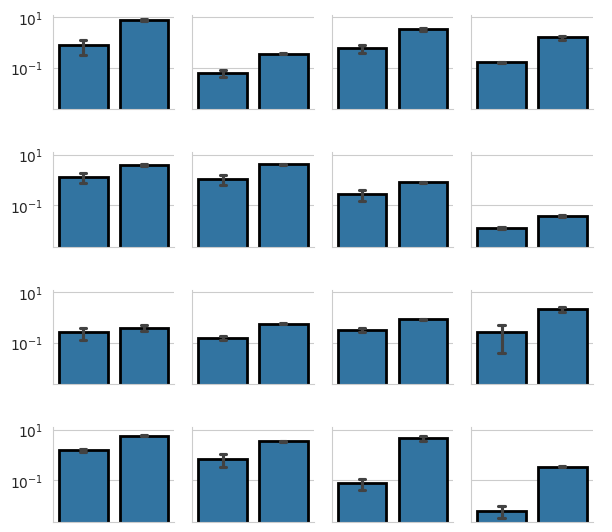

In [47]:
plt.figure(figsize = (4,4))
all = sns.catplot(data = summed, kind="bar",
            x="type_g", y="rel_ab", col="hacky",
            height=1.5, aspect=1,
            errorbar = "se", capsize = 0.1, ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2,
            col_wrap = 4, legend = "brief", legend_out = True 
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
#plt.savefig("all_ardley.png", bbox_inches= "tight")

In [48]:
len(summed["antib"].unique())

16

In [49]:
summed = all_data.loc[all_data["ambient"] == "lake"].groupby(["sample", "type_g", "antib", "or_seq"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
#summed["hacky"] = summed_am["ambient"] + " " + summed_am["type_g"]
summed["hacky"] = summed["or_seq"] + " " + summed["antib"]
summed.sort_values(by = "hacky", inplace = True)
summed.head()

,sample,type_g,antib,or_seq,rel_ab,hacky
0,1.0,control,Aminoglycoside,arg,0.019462,arg Aminoglycoside
160,11.0,plastic,Aminoglycoside,arg,0.009910,arg Aminoglycoside
48,4.0,control,Aminoglycoside,arg,0.020530,arg Aminoglycoside
272,18.0,plastic,Aminoglycoside,arg,0.009559,arg Aminoglycoside
256,17.0,plastic,Aminoglycoside,arg,0.014637,arg Aminoglycoside


<Figure size 400x400 with 0 Axes>

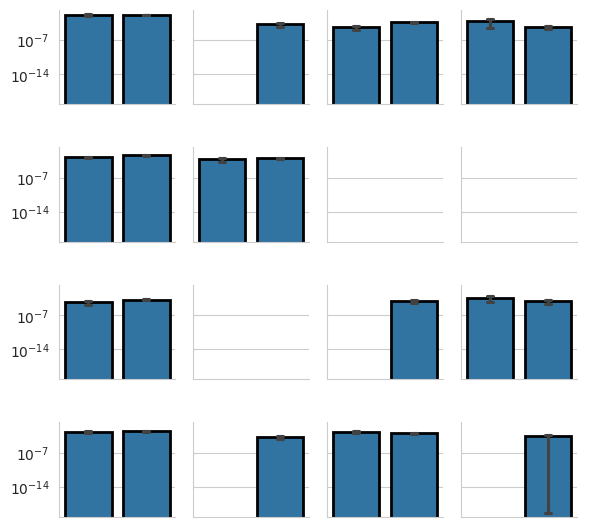

In [50]:
plt.figure(figsize = (4,4))
all = sns.catplot(data = summed, kind="bar",
            x="type_g", y="rel_ab", col="hacky",
            height=1.5, aspect=1,
            errorbar = "se", capsize = 0.1, ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2,
            col_wrap = 4, legend = "brief", legend_out = True 
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
#plt.savefig("all_lakes.png", bbox_inches= "tight")

In [51]:
print(summed["hacky"].unique())

['arg Aminoglycoside' 'arg Amphenicol' 'arg Beta Lactam'
 'arg Fluoroquinolone' 'arg MDR' 'arg MLSB' 'arg Other' 'arg Sulfonamide'
 'arg Tetracycline' 'arg Trimethoprim' 'arg Vancomycin' 'mge Insertional'
 'mge Integrase' 'mge MGE' 'mge Plasmid' 'mge Transposase']


#### GRÁFICAS DE TYPE_F

In [52]:
summed = all_data.loc[all_data["ambient"] == "ard"].groupby(["sample", "type_f", "antib", "or_seq"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed["hacky"] = summed["or_seq"] + " " + summed["antib"]
summed.sort_values(by = "hacky", inplace = True)
summed.head()

,sample,type_f,antib,or_seq,rel_ab,hacky
0,19.0,soil,Aminoglycoside,arg,0.435927,arg Aminoglycoside
80,24.0,EPS,Aminoglycoside,arg,6.391315,arg Aminoglycoside
48,22.0,EPS,Aminoglycoside,arg,7.923626,arg Aminoglycoside
112,26.0,PUR,Aminoglycoside,arg,7.386266,arg Aminoglycoside
32,21.0,soil,Aminoglycoside,arg,0.197495,arg Aminoglycoside


In [53]:
summed.loc[summed["type_f"] == "soil", "type_f"] = "1"
summed.loc[summed["type_f"] == "water", "type_f"] = "2"
summed.loc[summed["type_f"] == "EPS", "type_f"] = "3"
summed.loc[summed["type_f"] == "PUR", "type_f"] = "4"
summed.head()
palette = ("#B26F2C", "#B22C2C", "#85B22C")
#palette = ("#B22C2C", "#85B22C", "#B26F2C", "#2C85B2")

<Figure size 400x400 with 0 Axes>

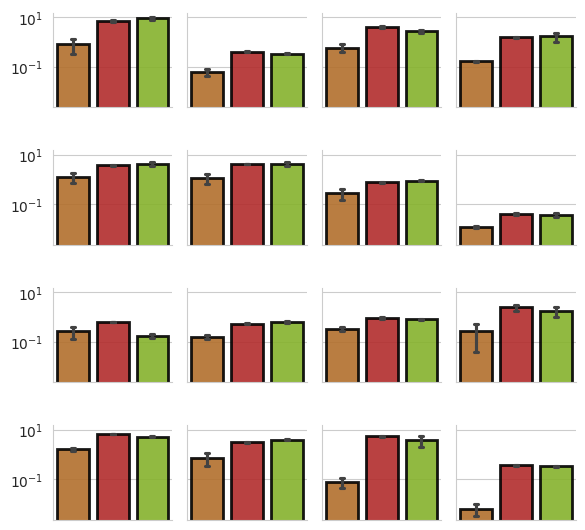

In [54]:
plt.figure(figsize = (4,4))
all = sns.catplot(data = summed, kind="bar",
            x="type_f", y="rel_ab", col="hacky",
            height=1.5, aspect=1,
            errorbar = "se", capsize = 0.1, ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2,
            col_wrap = 4, palette = palette, saturation = 1, alpha = 0.9
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
#plt.savefig("all_ard_typef.png", bbox_inches= "tight")

In [55]:
summed = all_data.loc[all_data["ambient"] == "lake"].groupby(["sample", "type_f", "antib", "or_seq"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed["hacky"] = summed["or_seq"] + " " + summed["antib"]
summed.sort_values(by = "hacky", inplace = True)
summed.head()

,sample,type_f,antib,or_seq,rel_ab,hacky
0,1.0,soil,Aminoglycoside,arg,0.019462,arg Aminoglycoside
160,11.0,PUR,Aminoglycoside,arg,0.009910,arg Aminoglycoside
48,4.0,water,Aminoglycoside,arg,0.020530,arg Aminoglycoside
272,18.0,PUR,Aminoglycoside,arg,0.009559,arg Aminoglycoside
256,17.0,PUR,Aminoglycoside,arg,0.014637,arg Aminoglycoside


In [56]:
summed.loc[summed["type_f"] == "soil", "type_f"] = "1"
summed.loc[summed["type_f"] == "water", "type_f"] = "2"
summed.loc[summed["type_f"] == "EPS", "type_f"] = "3"
summed.loc[summed["type_f"] == "PUR", "type_f"] = "4"
summed["hacky2"] = summed["hacky"] + " " + summed["type_f"]
summed.sort_values(by = "hacky2", inplace = True)
palette = ("#B22C2C", "#85B22C", "#B26F2C", "#2C85B2")
summed.head()

,sample,type_f,antib,or_seq,rel_ab,hacky,hacky2
0,1.0,1,Aminoglycoside,arg,0.019462,arg Aminoglycoside,arg Aminoglycoside 1
32,3.0,1,Aminoglycoside,arg,0.004266,arg Aminoglycoside,arg Aminoglycoside 1
16,2.0,1,Aminoglycoside,arg,0.003281,arg Aminoglycoside,arg Aminoglycoside 1
192,13.0,1,Aminoglycoside,arg,0.000064,arg Aminoglycoside,arg Aminoglycoside 1
48,4.0,2,Aminoglycoside,arg,0.020530,arg Aminoglycoside,arg Aminoglycoside 2


<Figure size 400x400 with 0 Axes>

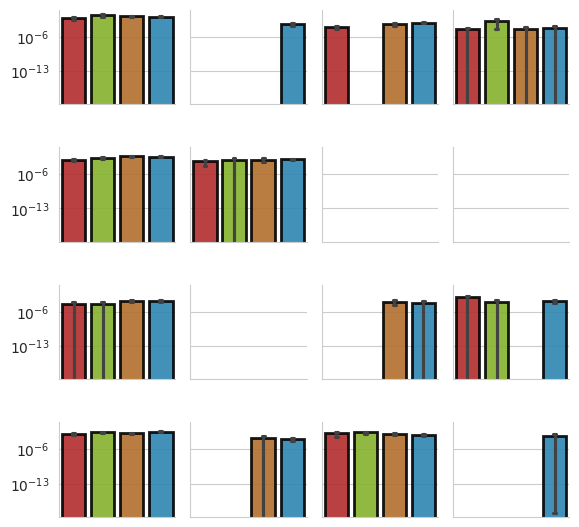

In [57]:
plt.figure(figsize = (4,4))
all = sns.catplot(data = summed, kind="bar",
            x="type_f", y="rel_ab", col="hacky",
            height=1.5, aspect=1,
            errorbar = "se", capsize = 0.1, ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2,
            col_wrap = 4, palette = palette, saturation = 1, alpha = 0.9 
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
#plt.savefig("all_lakes_typef.png", bbox_inches= "tight")

## Data differentiated by synthetic or not
As the title says, now I want to do the same type of analysis as in the antibiotic /MGE type analysis, but this time differentiating ARGs by whether they code for a synthetic, semi-synthetic or natural resistance

In [58]:
# First I need to define what is and what isn't a synthetic ARG
# This should have been fixed before
all_data.loc[all_data["antib"] == "MLSB", "antib"] = "Macrolide"

# Here goes everything that isn't classified as "Other"
all_data.loc[all_data["antib"] == "Aminoglycoside", "synth"] = "Natural"
all_data.loc[all_data["antib"] == "Amphenicol", "synth"] = "Semi-synthetic"
all_data.loc[all_data["antib"] == "Beta Lactam", "synth"] = "Natural" #!
all_data.loc[all_data["antib"] == "Fluoroquinolone", "synth"] = "Synthetic"
all_data.loc[all_data["antib"] == "MDR", "synth"] = "Natural"
all_data.loc[all_data["antib"] == "Macrolide", "synth"] = "Natural" #!
all_data.loc[all_data["antib"] == "Sulfonamide", "synth"] = "Synthetic"
all_data.loc[all_data["antib"] == "Tetracycline", "synth"] = "Natural" #!
all_data.loc[all_data["antib"] == "Trimethoprim", "synth"] = "Synthetic"
all_data.loc[all_data["antib"] == "Vancomycin", "synth"] = "Natural"

# Here the "Other" ARGs get classified family by family
all_data.loc[(all_data["Assay"] == "ARR-3") | (all_data["Assay"] == "Arr2") , "synth"] = "Semi-synthetic"
all_data.loc[all_data["Assay"] == "bacA", "synth"] = "Natural"
all_data.loc[all_data["Assay"] == "fabK", "synth"] = "Synthetic"
all_data.loc[(all_data["Assay"] == "fosX") | (all_data["Assay"] == "fosb") , "synth"] = "Natural"
all_data.loc[(all_data["Assay"] == "mcr-1") | (all_data["Assay"] == "mcr-2") | (all_data["Assay"] == "pmrA") , "synth"] = "Natural"
all_data.loc[all_data["Assay"] == "nisB", "synth"] = "Natural"

In [62]:
# Quickly change the directory
print(os.getcwd())
os.chdir("../synth_res")
print(os.getcwd())

/home/pak/Desktop/ARG-L/resistome/results/NCN_study/fam_res
/home/pak/Desktop/ARG-L/resistome/results/NCN_study/synth_res


In [72]:
# And now, the same loop as before but for the new synth column
for synth in all_data.loc[all_data["or_seq"] == "arg"]["synth"].unique():
    print("##### Working on ", synth.upper(), " #####")
    synth_data = all_data.loc[all_data["synth"] == synth]
        
    sp_grouped = synth_data.groupby(["sample", "ambient", "type_f"]) 
    summed_samples = sp_grouped["rel_ab"].sum() 
    summed_samples = summed_samples.reset_index() 
    summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"] + 1)

    for ambient in summed_samples["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby(["type_f"])] 
        nam_lst = [name for name, group in ambient_samples.groupby(["type_f"])] 
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby(["type_f"])]
        fname = synth.upper() + "-" + ambient.upper() + "-typef-" + "-statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            try:
                print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
                print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
                print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            except:
                print("Log2_values: ", stats.levene(*var_lst_ln), file = file)     
        posthoc = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
        posthoc.rename(columns = {original_num:new_name for (original_num, new_name) in zip(posthoc.columns, nam_lst)},
                       index = {original_num:new_name for (original_num, new_name) in zip(posthoc.index, nam_lst)},
                       inplace = True)
        fname = synth.upper() + "-" + ambient.upper() + "-typef-" + ".csv"
        posthoc.to_csv(fname)

##### Working on  NATURAL  #####
Working on  LAKE
Working on  ARD
##### Working on  SEMI-SYNTHETIC  #####
Working on  LAKE
Working on  ARD
##### Working on  SYNTHETIC  #####
Working on  LAKE
Working on  ARD


In [73]:
# Just have one thing left in terms of analysis: the plastics vs control comparisons
test = all_data.loc[all_data["or_seq"] == "arg"].groupby(["sample", "type_g", "synth", "ambient"])
summed = test["rel_ab"].sum().reset_index()
summed["n_log2"] = np.log2(summed["rel_ab"] + 1)
summed["group"] = summed["synth"] + "+" + summed["ambient"]

for group in summed["group"].unique():
    group_df = summed.loc[summed["group"] == group]
    pl_data = group_df.loc[summed["type_g"] == "plastic"]["n_log2"]
    con_data = group_df.loc[summed["type_g"] == "control"]["n_log2"]

    norm_plas = stats.shapiro(pl_data)
    norm_con = stats.shapiro(con_data)
        
    if (norm_plas[1] > 0.05) and (norm_con[1] > 0.05):
        norm = True
        homo = stats.bartlett(pl_data, con_data)
    else: 
        norm = False
        homo = stats.levene(pl_data, con_data)
            
    if (homo[1] > 0.05) and (norm == True): 
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided")
    elif (homo[1] > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = pl_data, y = con_data, alternative = "two-sided")
    elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
        result = stats.ttest_ind(a = pl_data, b = con_data, alternative = "two-sided", equal_var = False)
        result = ("Welch!", result[0], result[1])
    else: 
        result = stats.permutation_test(data = (pl_data, con_data), statistic =  statistic_mean, 
                                        vectorized = True, n_resamples = 20000,
                                        alternative = "two-sided", permutation_type = "independent")
        result = ("Permutation", result.pvalue, result.statistic) #ugly hack!

    fname = group.upper() + "-typeg.txt"
    with open(fname, "w") as file:
        print("##### ", group.upper(), " ####", file = file)
        print("### PLASTIC NORMALITY ###", file = file)
        print(norm_plas, file = file)
        print("### CONTROL NORMALITY ###", file = file)
        print(norm_con, file = file)
        print("### BOTH ###", file = file)
        print(homo, file = file)
        print("### DIFFERENCES ###", file = file)
        print(result, file = file)
        print("", file = file)


# Graphs
Now that we have the stats, we can make barplots again

In [76]:
summed = all_data.loc[(all_data["ambient"] == "ard") & (all_data["or_seq"] == "arg")].groupby(["sample", "type_g", "synth"])["rel_ab"].sum().reset_index() 
summed.sort_values(by = "synth", inplace = True)
summed.tail()

,sample,type_g,synth,rel_ab
20,25.0,plastic,Synthetic,3.011921
2,19.0,control,Synthetic,0.370825
23,26.0,plastic,Synthetic,0.883042
11,22.0,plastic,Synthetic,2.231649
26,27.0,plastic,Synthetic,3.096678


<Figure size 800x800 with 0 Axes>

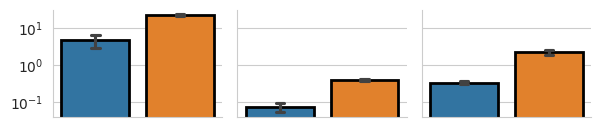

In [98]:
plt.figure(figsize = (8,8))
all = sns.catplot(data = summed, kind="bar",
            x="type_g", y="rel_ab", col="synth",
            height=2, aspect=1, hue = "type_g",
            errorbar = "se", capsize = 0.1, #ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2,
            col_wrap = 4, legend = False, legend_out = True 
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
#plt.savefig("typeg_ardley.png", bbox_inches= "tight")

<Figure size 800x800 with 0 Axes>

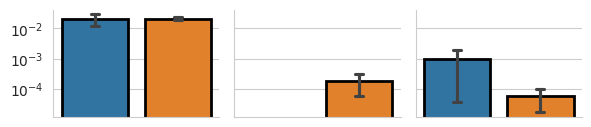

In [106]:
summed = all_data.loc[(all_data["ambient"] == "lake") & (all_data["or_seq"] == "arg")].groupby(["sample", "type_g", "synth"])["rel_ab"].sum().reset_index() 
summed.sort_values(by = "synth", inplace = True)

plt.figure(figsize = (8,8))
all = sns.catplot(data = summed, kind="bar",
            x="type_g", y="rel_ab", col="synth",
            height=2, aspect=1, hue = "type_g",
            errorbar = "se", capsize = 0.1, #ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2,
            col_wrap = 4, legend = None, legend_out = True 
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
plt.savefig("typeg_lake.png", bbox_inches= "tight")

<Figure size 800x800 with 0 Axes>

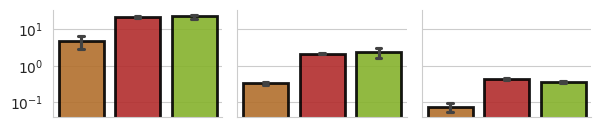

In [117]:
summed = all_data.loc[(all_data["ambient"] == "ard") & (all_data["or_seq"] == "arg")].groupby(["sample", "type_f", "synth"])["rel_ab"].sum().reset_index() 
summed.sort_values(by = "synth", inplace = True)

summed.loc[summed["type_f"] == "soil", "type_f"] = "1"
summed.loc[summed["type_f"] == "water", "type_f"] = "2"
summed.loc[summed["type_f"] == "EPS", "type_f"] = "3"
summed.loc[summed["type_f"] == "PUR", "type_f"] = "4"
summed.sort_values(by = "type_f", inplace = True)
palette = ("#B26F2C", "#B22C2C", "#85B22C")

plt.figure(figsize = (8,8))
all = sns.catplot(data = summed, kind="bar",
            x="type_f", y="rel_ab", col="synth",
            height=2, aspect=1, hue = "type_f",
            errorbar = "se", capsize = 0.1, #ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2, saturation = 1, alpha = 0.9,
            col_wrap = 4, legend = None, legend_out = True,
            palette = palette
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
plt.savefig("typef_ardley.png", bbox_inches= "tight")

<Figure size 800x800 with 0 Axes>

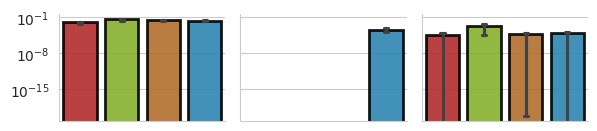

In [122]:
summed = all_data.loc[(all_data["ambient"] == "lake") & (all_data["or_seq"] == "arg")].groupby(["sample", "type_f", "synth"])["rel_ab"].sum().reset_index() 
summed.sort_values(by = "synth", inplace = True)

summed.loc[summed["type_f"] == "soil", "type_f"] = "1"
summed.loc[summed["type_f"] == "water", "type_f"] = "2"
summed.loc[summed["type_f"] == "EPS", "type_f"] = "3"
summed.loc[summed["type_f"] == "PUR", "type_f"] = "4"
summed.sort_values(by = "type_f", inplace = True)
palette = ("#B22C2C", "#85B22C", "#B26F2C", "#2C85B2")

plt.figure(figsize = (8,8))
all = sns.catplot(data = summed, kind="bar",
            x="type_f", y="rel_ab", col="synth",
            height=2, aspect=1, hue = "type_f",
            errorbar = "se", capsize = 0.1, #ecolor = "black",
            fill = True,  edgecolor = "black", linewidth = 2, saturation = 1, alpha = 0.9,
            col_wrap = 4, legend = None, legend_out = True,
            palette = palette
           )
plt.yscale("log")
#all.set(xticklabels = [], yticklabels = [],
#      xlabel=None, ylabel = None)
all.set(xticklabels = [], xlabel=None, ylabel = None)
all.set_titles("")
plt.savefig("typef_lake.png", bbox_inches= "tight")